In [56]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim

### Read data

[Know more about the data - The Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html#:~:text=The%20Boston%20Housing%20Dataset,the%20area%20of%20Boston%20Mass.)

In [57]:
X, y = shap.datasets.boston()

In [58]:
X.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


In [60]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

### Linear Regression

In [61]:
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

In [62]:
preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
reg = sm.OLS(y_train, preprocessed_X_train).fit()

In [63]:
def evaluate(X, y, mapper=None, reg=None, transform=False):
    if transform:
        X = mapper.transform(X)
        X = sm.add_constant(X, has_constant='add') 
    y_pred = reg.predict(X)
    return mean_absolute_error(y, y_pred)

In [64]:
train_mae = evaluate(X_train, y_train, mapper, reg, True)
test_mae = evaluate(X_test, y_test, mapper, reg, True)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 3.388, test MAE = 2.52 


In [65]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     97.41
Date:                Sun, 23 May 2021   Prob (F-statistic):          1.35e-120
Time:                        00:34:08   Log-Likelihood:                -1361.2
No. Observations:                 455   AIC:                             2750.
Df Residuals:                     441   BIC:                             2808.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7675      0.240     95.013      0.000      22.297      23.238
CRIM          -0.9544      0.316     -3.021      0.003      -1.575      -0.333
ZN             1.1903      0.347      3.426      0.001       0.508       1.873
INDUS          0.2159      0.445      0.485      0.628      -0.659       1.091
NOX           -2.0944      0.505     -4.148      0.000      -3.087      -1.102
RM             2.7612      0.317      8.700      0.000       2.137       3.385
AGE            0.3042      0.411      0.739      0.460      -0.504       1.113
DIS           -3.1207      0.460     -6.788      0.000      -4.024      -2.217
RAD            2.9649      0.678      4.372      0.000       1.632       4.298
TAX           -2.4522      0.715     -3.430      0.001      -3.857      -1.047
PTRATIO       -2.0042      0.310     -6.468      0.000      -2.613      -1.395
B              0.8742      0.272      3.213      0.001       0.339       1.409
LSTAT         -4.0539      0.394    -10.283      0.000      -4.829      -3.279
CHAS           2.5088      0.895      2.804      0.005       0.750       4.267
==============================================================================
Omnibus:                      152.667   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.005
Skew:                           1.474   Prob(JB):                    2.80e-129
Kurtosis:                       7.747   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = RandomForestRegressor()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

train_mae = evaluate(X_train, y_train, reg=pipeline)
test_mae = evaluate(X_test, y_test, reg=pipeline)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 0.784, test MAE = 2.706 


<BarContainer object of 13 artists>

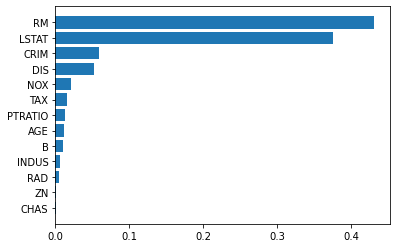

In [68]:
sorted_idx = reg.feature_importances_.argsort()
features = numerical_features + catagorical_features 
result = sorted(zip(features, reg.feature_importances_), key = lambda x: x[1], reverse=False)
plt.barh([x[0] for x in result], [x[1] for x in result])

### Neural Network

In [69]:
#Constructed using pytorch
preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
#One hidden layer with output layer
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Mini batch gradient descent to process all these batches

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")
#Model performs really well and is probably better than all the rest here 

Epoch 0, Loss: 5589.269958496094
Epoch 10, Loss: 423.0964059829712
Epoch 20, Loss: 224.5963430404663
Epoch 30, Loss: 217.15503978729248
Epoch 40, Loss: 214.87851428985596

train MAE = 3.398, test MAE = 2.48 



We don't have a direct way to identify feature importance for neural networks

### Problems with Interpretation
1. No specific method to define feature importance that is model agnostic

2. For a given sample, why does the prediction have that value?

Answer: Shap values


### Intuition of Model Interpretation

How we think about answering the question "Why is the output for this specific sample so low/high" manually?

In [70]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) #revert
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [SimpleImputer(strategy='constant', fill_value=0),
              OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = LinearRegression()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

In [71]:
nan_frame = pd.DataFrame(columns=catagorical_features+numerical_features, index=[0])
nan_frame

,CHAS,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
base_value = round(pipeline.predict(nan_frame)[0], 3)
print(f"Expected value of the output (base value): {base_value}")

Expected value of the output (base value): 22.767


In [73]:
X_test.iloc[0: 1]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
455,4.75237,0.0,18.1,0.0,0.713,6.525,86.5,2.4358,24.0,666.0,20.2,50.92,18.13


In [74]:
sample_prediction = round(pipeline.predict(X_test.iloc[0: 1])[0], 3)
print(f"Current Prediction: {sample_prediction}, Actual value: {y_test[0]}")

Current Prediction: 15.851, Actual value: 14.1


In [75]:
#'shap.Explainer'- Uses Shapley values to explain any machine learning model on a given dataset
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 52it [00:15,  1.20it/s]                                                                         


In [76]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

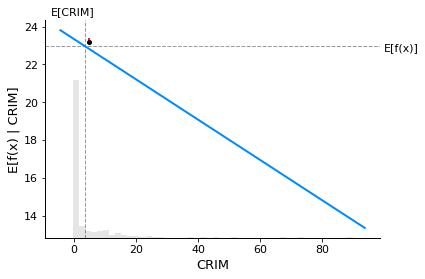

In [77]:
partial_dependence_plot('CRIM', 0)

In [78]:
X_test.iloc[0: 1]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
455,4.75237,0.0,18.1,0.0,0.713,6.525,86.5,2.4358,24.0,666.0,20.2,50.92,18.13


This variable output has a huge difference from the model expected output.It has a huge impact on the model output increasing 
it by 5 and half somethingRed line becomes the contribution of this feature RAD by this particular sample ie index 0 of test set
and the magnitude of this red line is the shapely value.
So we can have a shapely value for every sample, every feature of every single sample in our entire dataset

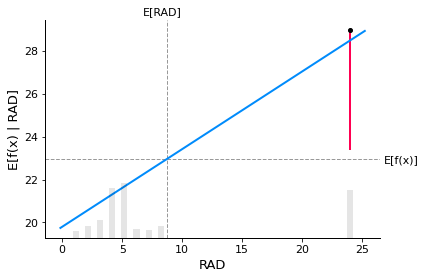

In [79]:
partial_dependence_plot('RAD', 0)

### Shap Plots
Hard to look at every feature for every sample. So lets look at all features of the same sample

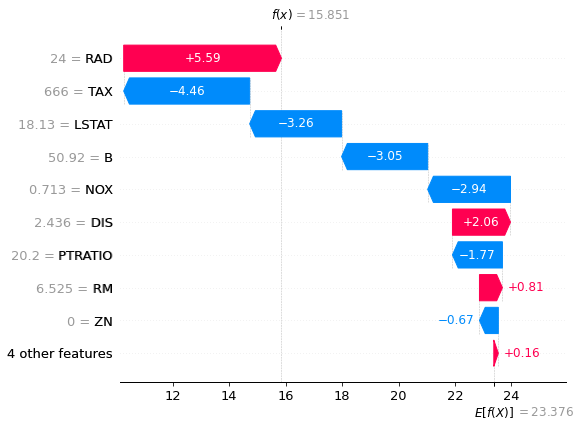

In [80]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

# Waterfall plot
sample_feature_importance(0, 'waterfall')

1. RAD has huge influence in increasing the house prices for this particular sample.
2. TAX and LSTAT has major contribution in bringing the prices down.

We are able to visually interpret why exactly this specific sample is giving an output of 15.851.

In [81]:
#Condensed plot
sample_feature_importance(0, 'condensed')

Above plots were for for individual samples.But Now what if we want to bubble up to determine the model importance.

We take the shap values of every single sample of every feature and we take the mean of the absolute value of the shapely value

This plot where the shapely values will be proportional to contribution

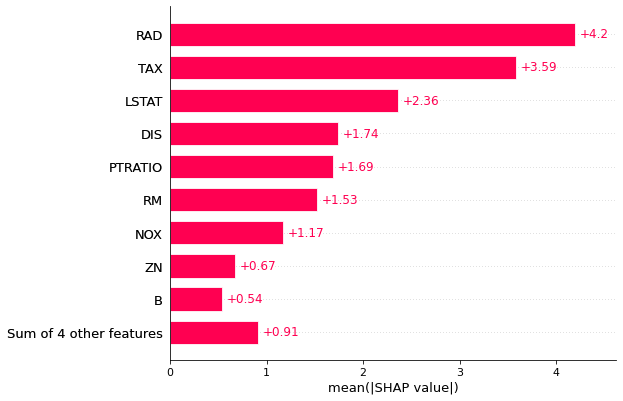

In [82]:
shap.plots.bar(shap_values)

Two most important features according to the LinearRegression model:

* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per $10,000

A variable importance plot lists the most significant variables in descending order. 
The top variables contribute more to the model than the bottom ones and thus have high predictive power.

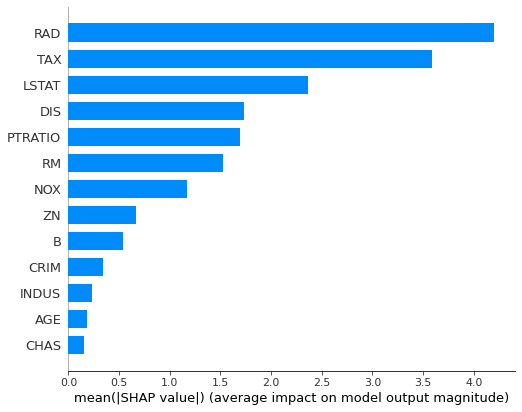

In [83]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

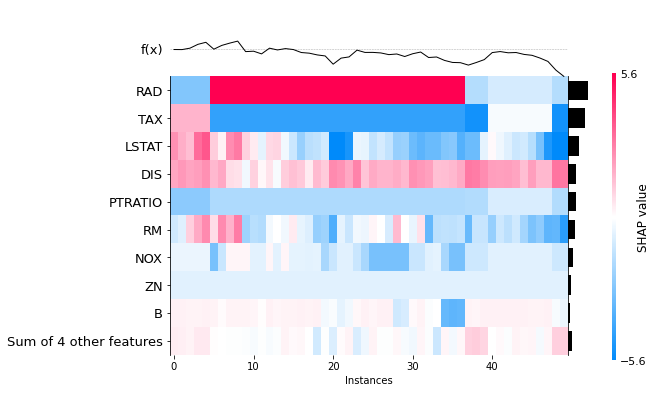

In [84]:

shap.plots.heatmap(shap_values[1:100])

##### We can interpret the neural network model in the same way

In [33]:
preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 5542.754959106445
Epoch 10, Loss: 294.39962005615234
Epoch 20, Loss: 217.39130878448486
Epoch 30, Loss: 213.71986293792725
Epoch 40, Loss: 212.98408126831055

train MAE = 3.394, test MAE = 2.509 


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


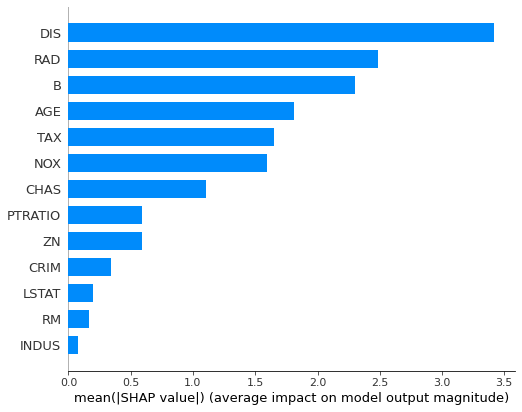

In [34]:
explainer = shap.DeepExplainer(model, torch.from_numpy(preprocessed_X_train.values).float())
shap_values = explainer.shap_values(torch.from_numpy(preprocessed_X_test.values).float())
shap.summary_plot(shap_values, X_test, plot_type='bar')

# We can check the feature importance using the plot

### Interpret Image classification model

In [85]:
from tensorflow import keras
from tensorflow.keras import layers

[MNIST handwritten digit database](http://yann.lecun.com/exdb/mnist/)

The goal is to implement a CNN to clasify MNIST handwritten digit images

In [86]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


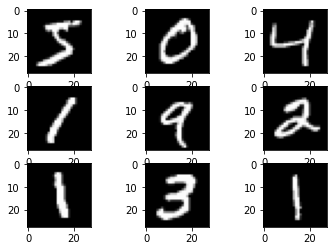

In [87]:
# plot first few images
from matplotlib import pyplot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [88]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [89]:
## https://www.youtube.com/watch?v=d4PPMpdUCz8&ab_channel=Databricks

In [90]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 34s 77ms/step - loss: 0.7519 - accuracy: 0.7703 - val_loss: 0.0778 - val_accuracy: 0.9782
Epoch 2/15
422/422 [==============================] - 33s 77ms/step - loss: 0.1208 - accuracy: 0.9626 - val_loss: 0.0521 - val_accuracy: 0.9865
Epoch 3/15
422/422 [==============================] - 31s 73ms/step - loss: 0.0857 - accuracy: 0.9743 - val_loss: 0.0487 - val_accuracy: 0.9863
Epoch 4/15
422/422 [==============================] - 32s 75ms/step - loss: 0.0696 - accuracy: 0.9788 - val_loss: 0.0390 - val_accuracy: 0.9890
Epoch 5/15
422/422 [==============================] - 31s 74ms/step - loss: 0.0574 - accuracy: 0.9818 - val_loss: 0.0375 - val_accuracy: 0.9895
Epoch 6/15
422/422 [==============================] - 33s 78ms/step - loss: 0.0546 - accuracy: 0.9835 - val_loss: 0.0347 - val_accuracy: 0.9902
Epoch 7/15
422/422 [==============================] - 30s 71ms/step - loss: 0.0498 - accuracy: 0.9838 - val_loss: 0.0340 - val_accuracy:

In [91]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.026151733472943306
Test accuracy: 0.9912999868392944


In [92]:
e = shap.DeepExplainer(model, x_train[:100])
shap_values = e.shap_values(x_test[1:10])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


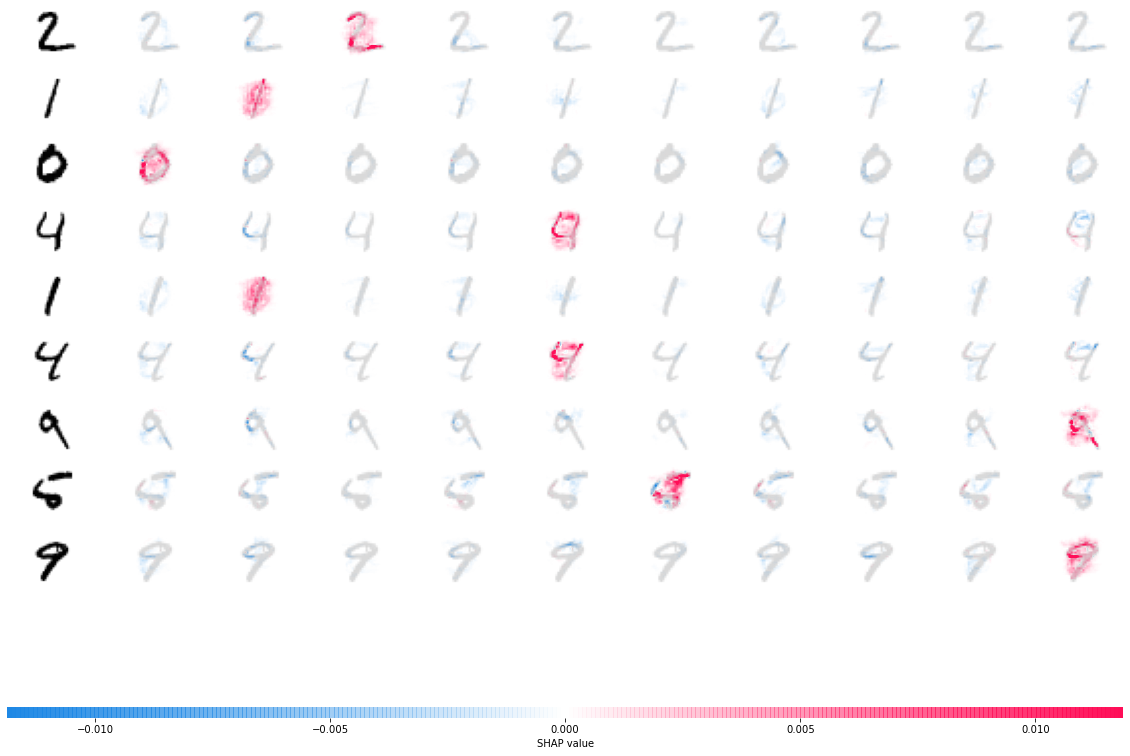

In [93]:
#The plot above shows the explanations for each class on four predictions. Note that the explanations are ordered for the classes 0-9 going left to right along the rows.
shap.image_plot(shap_values,-x_test[1:10])

### Interpret Text Model: Sentimental Analysis

In [47]:
### Text Analytics
#https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.html

In [48]:
import transformers
import datasets

In [49]:
dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit into the pipeline model
short_data = [v[:500] for v in dataset["text"][:20]]

Reusing dataset imdb (C:\Users\40103050\.cache\huggingface\datasets\imdb\plain_text\1.0.0\4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b)


In [50]:
# Load and run a sentiment analysis pipeline

classifier = transformers.pipeline('sentiment-analysis', return_all_scores=True)
classifier(short_data[:2])

[[{'label': 'NEGATIVE', 'score': 0.0012035148683935404},
  {'label': 'POSITIVE', 'score': 0.9987965226173401}],
 [{'label': 'NEGATIVE', 'score': 0.0022187805734574795},
  {'label': 'POSITIVE', 'score': 0.9977812170982361}]]

In [51]:
short_data[:1]

["I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the "]

In [52]:
#Explain the sentimental analysis pipeline
# define the explainer
explainer = shap.Explainer(classifier)
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:2])

Partition explainer:  50%|███████████████████████████████████▌                                   | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:21, 10.50s/it]                                                                            


In [96]:
shap.plots.text(shap_values[:,:,"POSITIVE"])

TypeError: list indices must be integers or slices, not tuple

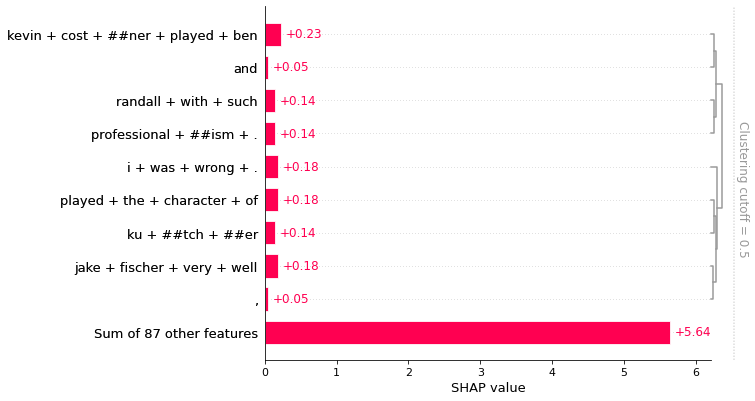

In [54]:
shap.plots.bar(shap_values[0,:,"POSITIVE"])